In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
from tqdm.notebook import tqdm
import time

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import glob
import os
import sys

from tqdm.notebook import tqdm
from datetime import datetime

import Cross_Eval
from Preprocessing_Methods import *

In [5]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer, RobustScaler, MinMaxScaler, StandardScaler, LabelBinarizer
from sklearn.preprocessing import normalize, robust_scale, minmax_scale

from sklearn.preprocessing import OneHotEncoder,KBinsDiscretizer
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.calibration import CalibratedClassifierCV

from sklearn.kernel_approximation import RBFSampler, Nystroem

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GroupKFold, KFold

from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, f1_score, recall_score, accuracy_score

from sklearn.multiclass import OneVsRestClassifier

from mlxtend.evaluate import scoring

# Preparing Metadata/Labels

In [6]:
all_files = pd.DataFrame(glob.glob("/mnt/d/Conor/Extracted_Spectra/*.pickle"), columns = ["hdf_loc"])
all_files["TMA"] = all_files.apply(lambda row: float(row["hdf_loc"].split("/")[-1][4:5]), axis = 1)
all_files["Core"] = all_files.apply(lambda row: row["hdf_loc"].split("/")[-1][8:-7], axis = 1)

In [7]:
metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/Scoring grids Advancing Front (TMAs 1-3).xlsx"
              , sheet_name = "reformatted")

metadata = metadata.merge(all_files, left_on = ["TMA", "TMA site"], right_on = ["TMA", "Core"])
print(metadata.shape)

(79, 18)


In [8]:
new_metadata = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/new_metadata.xlsx")

In [9]:
new_metadata["DODvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "DOD",
                             "alive": "Other",
                             "died other" : "Other",
                             "died" : "Other",
                             "Died" : "Other",
                             "Died other": "Other"})

new_metadata["DiedvsAlive"] = new_metadata["OUTCOME"].map(
                            {"DOD" : "Died",
                             "alive": "Alive",
                             "died other" : "Died",
                             "died" : "Died",
                             "Died" : "Died",
                             "Died other": "Died"})

new_metadata["ECS"] = new_metadata["ECS"].map(
                            {"y" : "Y",
                             "Y": "Y",
                             "N" : "N",
                             "n" : "N"})

In [10]:
new_metadata['lifespan'] = new_metadata['Date of death'] - new_metadata['date of diag']
new_metadata["Years"] = new_metadata['Date of death'].dt.year - new_metadata['date of diag'].dt.year

In [11]:
# Did the patient survive beyond n years?
for i in np.arange(0,5,1):
    
    s = (365*i)
    e = (365*(i+2))
    
    new_metadata[f"{i+1}year"] = new_metadata.apply(lambda row: True if s<(row['lifespan']).days<e and row.OUTCOME not in ['Alive',"alive"] else False, axis = 1)

In [12]:
bins = np.arange(0, new_metadata["Years"].max(),2)

new_metadata["2years"] = np.digitize(new_metadata["Years"], bins)

In [13]:
new_metadata

,Patient_Number,gender,date of diag,age @ diag,site,pT,pN,stage,ECS,OUTCOME,...,DODvsAlive,DiedvsAlive,lifespan,Years,1year,2year,3year,4year,5year,2years
0,3143,m,2004-03-29,58,floor of mouth,4,0,4,N,DOD,...,DOD,Died,3341 days,9.0,False,False,False,False,False,5
1,3167,m,2004-09-30,74,floor of mouth,2,2,4,Y,DOD,...,DOD,Died,390 days,1.0,True,True,False,False,False,1
2,3169,m,2004-10-28,63,floor of mouth,3,1,3,N,died other,...,Other,Died,652 days,2.0,True,True,False,False,False,2
3,3170,m,2004-11-22,59,other,4,2b,4a,Y,Died other,...,Other,Died,3690 days,10.0,False,False,False,False,False,6
4,3230,m,2006-01-26,74,tongue,2,1,3,Y,DOD,...,DOD,Died,161 days,0.0,True,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,3647,f,2010-10-18,60,tongue,3,2b,NaN,Y,died,...,Other,Died,184 days,1.0,True,False,False,False,False,1
103,3706,f,2011-04-14,64,tongue,3,0,NaN,N,alive,...,Other,Alive,NaT,NaN,False,False,False,False,False,6
104,3743,m,2011-11-17,40,tongue,2,0,NaN,N,alive,...,Other,Alive,NaT,NaN,False,False,False,False,False,6
105,3763,m,2012-02-13,57,floor of mouth,3,2b,4a,Y,died,...,Other,Died,172 days,0.0,True,False,False,False,False,1


Import ASMA data

In [14]:
asma = pd.read_excel("/mnt/b/Google_Drive/PhD/Project with Janet/ASMA.xlsx", sheet_name = "Sheet3")
new_metadata = new_metadata.merge(asma, left_on = "Patient_Number", right_on = "Case ID")

# Import data and preprocess

In [15]:
from Preprocessing_Methods import *

import sys

sys.path.append("/mnt/b/Git_Projects/Biospec_Analysis/UNET")

In [16]:
select = ['Tumour']

total = pd.concat({"{}-{}".format(row["TMA"], row["Core"]):
                   truncate(pd.read_pickle(row["hdf_loc"]).query(f"Tissue in {select}").sample(frac = 1), start = 1000, end = 1800)
                   for name, row in tqdm(list(metadata.iterrows()))}, names = ["ID"])

wn_cols = total.columns
#total = total.merge(new_metadata, left_on = "Patient nu ", right_on = "Patient Number")
#total = total.drop(np.nan, level = "Overall Death ")

In [17]:
total = total.reset_index().merge(new_metadata, left_on = "Patient nu ", right_on = "Patient_Number", how = 'inner')
total = total.set_index(list(total.columns.difference(wn_cols))).dropna(axis = 1)

In [18]:
total.sample(5)

998.0   \
1year 2year 2years 3year 4year 5year ASMA Annotation_loc                                     Case ID Core_x Core_y Corrected Site AJCC/UICC DODvsAlive Date of death Date of recurrence Diagnosis Age DiedvsAlive ECS_x ECS_y ID      Last seen/reviewed Last updated N stage OUTCOME    OUTCOME.updated by Overall Death  Pathogical Stage Patient nu  Patient_Number Recurrence? T stage TMA TMA site Tissue Years advancing front type age @ diag date of diag diff   envi_loc                                           gender_x gender_y lifespan pN pT radiotherapy recurrence site           site of recurrence stage survival (months)             
True  False 1      False False False H    /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3568    C5     C5     FOM                      Other      2010-04-17    NaT                74.0          Died        yes   Y     1.0-C5  NaT                2020-04-01   2c      died other FGD                yes            pT2N2cMx         3568        3568           no          2       1.0 C5       Tumour 0.0   NaN                  74         2010-03-04   NaN    /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m        m        44 days  2c 2  no           no         floor of mouth NaN                4a    1.0               -0.238798   
                                          /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3251    B1     B1     oral tongue              DOD        2006-07-21    NaT                70.0          Died        yes   Y     2.0-B1  NaT                2020-03-13   1       DOD        FG                 yes            pT4N1M0          3251        3251           no          4       2.0 B1       Tumour 0.0   islands              70         2006-05-31   mod    /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m        m        51 days  1  4  no           no         tongue         NaN                4     2.0                0.044504   
      True  1      False False False I    /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3254    A2     A2     FOM                      DOD        2007-10-22    2007-08-09         48.0          Died        no    N     2.0-A2  NaT                2012-10-04   2c      DOD        CBarry             yes            pT2N2cMx         3254        3254           yes         2       2.0 A2       Tumour 1.0   islets               48         2006-06-12   mod    /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... f        f        497 days 2c 2  yes          yes        floor of mouth metastases         4     15.0               0.017278   
False False 6      False False False L    /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3481    C3     C3     oropharynx               Other      NaT           NaT                60.0          Alive       no    N     1.0-C3  2020-01-29         2020-04-24   1       alive      FGD                no             pT2N1Mx          3481        3481           no          2       1.0 C3       Tumour NaN   non cohesive type 4  72         2009-02-23   poorly /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m        m        NaT      1  2  yes          yes        oropharynx     NaN                NaN   91.0               0.057470   
                                     I    /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3271    A10    A10    FOM                      Other      NaT           2010-07-23         59.0          Alive       yes   Y     1.0-A10 2010-07-23         2020-04-01   2b      alive      FGD                no             pT4N2bM0         3271        3271           yes         4       1.0 A10      Tumour NaN   poorly cohesive      59         2006-09-16   mod    /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m        m        NaT      2b 4  yes          yes        floor of mouth lung mets          4a    46.0               0.017562   

                                                                                                                                                                             

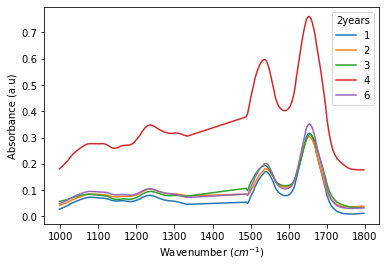

In [19]:
fig, axes = plt.subplots(nrows = 1, figsize = (6,4), sharex = True)

total.groupby("2years").mean().T.plot(ax = axes)
axes.set_xlabel("Wavenumber $(cm^{-1})$")
axes.set_ylabel("Absorbance (a.u)")
fig.savefig(os.getcwd()+ "/Plots/Mean_ECS_Spectra.png", bbox_inches = 'tight')

In [20]:
pcapipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
    ("Scaler", RobustScaler()),
    ("PCA", PCA())
])

In [21]:
n = total.reset_index()["Patient_Number"].value_counts().min()
total_ = total.groupby("Patient_Number", group_keys=False).apply(lambda g: g.sample(n))

Text(0, 0.5, 'N patients')

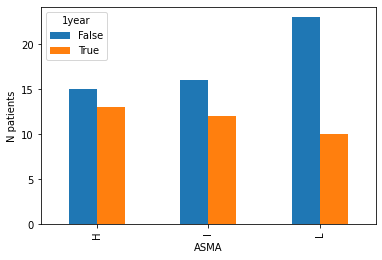

In [22]:
ax = pd.crosstab(new_metadata["ASMA"], new_metadata["1year"]).plot.bar()
ax.set_ylabel("N patients")

Text(0, 0.5, 'N patients')

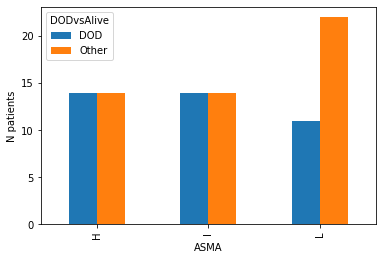

In [23]:
ax = pd.crosstab(new_metadata["ASMA"], new_metadata["DODvsAlive"]).plot.bar()
ax.set_ylabel("N patients")

## Regression stuff

## 

In [24]:
numeric_features = np.arange(2, len(total.columns)+1)
categorical_features = [0,1]

numeric_pipe = Pipeline([
("Normalise spectra", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
("Scaler", RobustScaler()),
("PCA", PCA()),
])

categorical_pipe = Pipeline([
    ("OneHot", OneHotEncoder())
])

preprocessing = ColumnTransformer(
    [("Numerical", numeric_pipe, numeric_features),
     ("Categorical", categorical_pipe, categorical_features)])

pipe = Pipeline([
    ("Preprocessing", preprocessing),
])

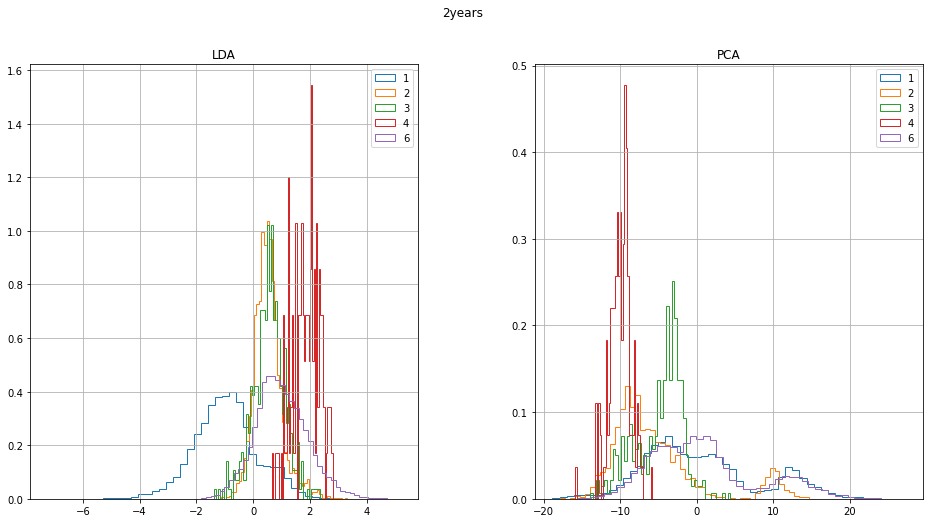

In [25]:
y = "2years"

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (16,8))
fig.suptitle(y)

data = total.copy().sample(frac = 0.1)#.drop(np.nan, level = "DODvsAlive")

total_lda = pd.DataFrame(
    LinearDiscriminantAnalysis(n_components = 1).fit_transform(pcapipe.fit_transform(data), data.reset_index()[f"{y}"].values)
    , index = data.index)


for name, df in total_lda.groupby(level = f"{y}"):

    df.hist(0, bins = 50, ax = ax1, histtype = 'step', label = name, density = True)

ax1.set_title("LDA")
ax1.legend()
    
total_pca = pd.DataFrame(
    PCA(n_components = 1).fit_transform(pcapipe.fit_transform(data), data.reset_index()[f"{y}"])
    , index = data.index)


for name, df in total_pca.groupby(level = f"{y}"):

    df.hist(0, bins = 50, ax = ax2, histtype = 'step', label = name, density = True)

ax2.set_title("PCA")
plt.legend()

In [25]:
ldapipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(robust_scale, kw_args = {"axis": 1})),
    ("Scaler", RobustScaler()),
    ("PCA", PCA()),
    ("clf", LinearDiscriminantAnalysis())
])

#totalpca = pcapipe.fit(total.append(paraffin))
#totalpca = pcapipe.fit(total.append(paraffin))

## Keras Tuner

In [26]:
import kerastuner as kt

In [27]:
def build_LDA(hp):
    
    scalers = {"Normalize" : normalize,
               "Robust"    : robust_scale,
               "MinMax"    : minmax_scale}
    
    scale1 = hp.Choice('scale1', ["Normalize", "Robust", "MinMax"])
    scale2 = hp.Choice('scale2', ["Normalize", "Robust", "MinMax"])


    pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(scalers[scale1] , kw_args = {"axis": 1})),
    ("Scaler", FunctionTransformer(scalers[scale2] , kw_args = {"axis": 0})),
    ("PCA", PCA(n_components = hp.Int("PCA_components", 1, len(data.columns) - 1, 1))),
    ("clf", CalibratedClassifierCV(LinearDiscriminantAnalysis()))])
    
    return pipe

In [27]:
def build_LR(hp):
    
    scalers = {"Normalize" : normalize,
               "Robust"    : robust_scale,
               "MinMax"    : minmax_scale}
    
    scale1 = hp.Choice('scale1', ["Normalize", "Robust", "MinMax"])
    scale2 = hp.Choice('scale2', ["Normalize", "Robust", "MinMax"])
    
    params = {
        "penalty"  : hp.Choice('Penalty', ["l2"]),
        "tol"      : hp.Float('Tolerance', 0, 1),
        "C"        : hp.Float('C', 1e-5, 1),
        "solver"   : "sag"
    }
    
    clf = LogisticRegression()
    clf.set_params(**params)


    pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(scalers[scale1] , kw_args = {"axis": 1})),
    ("Scaler", FunctionTransformer(scalers[scale2] , kw_args = {"axis": 0})),
    ("PCA", PCA(n_components = hp.Int("PCA_components", 1, len(data.columns) - 1, 1))),
    ("clf", CalibratedClassifierCV(clf))])
    
    return pipe

In [35]:
from sklearn.naive_bayes import GaussianNB

def build_NB(hp):
    
    scalers = {"Normalize" : normalize,
               "Robust"    : robust_scale,
               "MinMax"    : minmax_scale}
    
    scale1 = hp.Choice('scale1', ["Normalize", "Robust", "MinMax"])
    scale2 = hp.Choice('scale2', ["Normalize", "Robust", "MinMax"])
    
    clf = GaussianNB()
    
    #params = {
    #    "var_smoothing": hp.Float("var_smoothing", 1e-9, 1)}
    
    #clf.set_params(**params)


    pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(scalers[scale1] , kw_args = {"axis": 1})),
    ("Scaler", FunctionTransformer(scalers[scale2] , kw_args = {"axis": 0})),
    ("PCA", PCA(n_components = hp.Int("PCA_components", 1, len(data.columns) - 1, 1))),
    ("clf", CalibratedClassifierCV(clf))])
    
    return pipe

In [30]:
from keras.wrappers.scikit_learn import KerasClassifier

from keras.models import Sequential
import keras.layers as Layers

import tensorflow as tf

def build_NN(hp):
    
    scalers = {"Normalize" : normalize,
               "Robust"    : robust_scale,
               "MinMax"    : minmax_scale}
    
    scale1 = hp.Choice('scale1', ["Normalize", "Robust", "MinMax"])
    scale2 = hp.Choice('scale2', ["Normalize", "Robust", "MinMax"])
    
    pca_comps = hp.Int("PCA_components", 1, len(data.columns) - 1, 1)
    
    
    def build_keras():
        
        model = Sequential()
        model.add(Layers.Input(shape=(pca_comps,)))

        for i, layer_n in enumerate(range(hp.Int("N_layers", 2, 20))):

            model.add(Layers.Dense(hp.Int(f"layer_{i}_nodes", 5, 100), activation="relu"))

        model.add(Layers.Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy",optimizer="adam", metrics=[tf.keras.metrics.AUC()])
        
        return model
    
    
    clf=KerasClassifier(build_fn=build_keras,epochs=2,batch_size=32,verbose=0)    

    pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(scalers[scale1] , kw_args = {"axis": 1})),
    ("Scaler", FunctionTransformer(scalers[scale2] , kw_args = {"axis": 0})),
    ("PCA", PCA(n_components=pca_comps)),
    ("clf", clf)])
    
    return pipe

In [31]:
def build_LDA_categorical(hp):

    scalers = {"Normalize" : normalize,
               "Robust"    : robust_scale,
               "MinMax"    : minmax_scale}
    
    scale1 = hp.Choice('scale1', ["Normalize", "Robust", "MinMax"])
    scale2 = hp.Choice('scale2', ["Normalize", "Robust", "MinMax"])
    
    numeric_features = total.columns
    categorical_features = ["ECS"]
    
    numeric_features = np.arange(1, len(total.columns)+1)
    categorical_features = [0]
    
    numeric_pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(scalers[scale1] , kw_args = {"axis": 1})),
    ("Scaler", FunctionTransformer(scalers[scale2] , kw_args = {"axis": 0})),
    ("PCA", PCA(n_components = hp.Int("PCA_components", 1, len(data.columns) - len(categorical_features) - 2, 1))),
    ])
    
    OHE = OneHotEncoder()
    OHE.fit(data["ASMA"].values.reshape(-1,1))
    
    categorical_pipe = Pipeline([
        ("OneHot", OHE)
    ])
    
    preprocessing = ColumnTransformer(
        [("Numerical", numeric_pipe, numeric_features),
         ("Categorical", categorical_pipe, categorical_features)])
    
    pipe = Pipeline([
        ("Preprocessing", preprocessing),
        ("clf", LinearDiscriminantAnalysis())
    ])
    
    return pipe

In [32]:
def build_LDA_categorical(hp):

    scalers = {"Normalize" : normalize,
               "Robust"    : robust_scale,
               "MinMax"    : minmax_scale}
    
    scale1 = hp.Choice('scale1', ["Normalize", "Robust", "MinMax"])
    scale2 = hp.Choice('scale2', ["Normalize", "Robust", "MinMax"])
    
    numeric_features = total.columns
    categorical_features = ["ASMA"]
    
    numeric_features = np.arange(1, len(total.columns)+1)
    categorical_features = [0]
    
    numeric_pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(scalers[scale1] , kw_args = {"axis": 1})),
    ("Scaler", FunctionTransformer(scalers[scale2] , kw_args = {"axis": 0})),
    ("PCA", PCA(n_components = hp.Int("PCA_components", 1, len(data.columns) - len(categorical_features) - 2, 1))),
    ])
    
    OHE = OneHotEncoder()
    OHE.fit(data.reset_index()["ASMA"].values.reshape(-1,1))
    
    categorical_pipe = Pipeline([
        ("OneHot", OHE)
    ])
    
    preprocessing = ColumnTransformer(
        [("Numerical", numeric_pipe, numeric_features),
         ("Categorical", categorical_pipe, categorical_features)])
    
    pipe = Pipeline([
        ("Preprocessing", preprocessing),
        ("clf", LinearDiscriminantAnalysis())
    ])
    
    return pipe

In [33]:
def build_LDA_categorical_only(hp):

    OHE = OneHotEncoder(sparse = False)
    #OHE.fit(data.reset_index()["ASMA"].values.reshape(-1,1))
    
    categorical_pipe = Pipeline([
        ("OneHot", OHE)
    ])

    pipe = Pipeline([
        ("Preprocessing", categorical_pipe),
        ("clf", LinearDiscriminantAnalysis())
    ])
    
    return pipe

In [34]:
from xgboost import XGBClassifier

def build_XG(hp):

    params = {
        'n_estimators': hp.Int("n_estimators", 10, 1000, 10),
        'eta': hp.Float('eta', 0, 1, 0.05),
        'gamma': hp.Float('gamma', 0, 1, 0.05),
        'max_depth' : hp.Int('max_depth', 1, 15, 1),
        'min_child_weight' : hp.Int('min_child_weight', 1, 20, 1),
        'subsample' : hp.Float('subsample', 0, 1, 0.05),
        'colsample_bytree' : hp.Float('colsample_bytree', 0, 1, 0.05),
        #'lambda ' : hp.Float('lambda', 0, 1, 0.05),
        'alpha' : hp.Float('alpha', 0, 1, 0.05),
    }

    clf = XGBClassifier(objective = "binary:logistic")
    clf = clf.set_params(**params)
    
    #---------------------------------------------------------------------------------------------------
    scalers = {"Normalize" : normalize,
               "Robust"    : robust_scale,
               "MinMax"    : minmax_scale}
    
    # Decide pre processing steps
    scale1 = hp.Choice('scale1', ["Normalize", "Robust", "MinMax"])
    scale2 = hp.Choice('scale2', ["Normalize", "Robust", "MinMax"])

    pipe = Pipeline([
    ("Normalise spectra", FunctionTransformer(scalers[scale1] , kw_args = {"axis": 1})),
    ("Scaler", FunctionTransformer(scalers[scale2] , kw_args = {"axis": 0})),
    ("PCA", PCA(n_components = hp.Int("PCA_components", 1, len(data.columns) - 1, 1))),
    ("clf", CalibratedClassifierCV(clf))])
    
    return pipe

oracle = kt.oracles.BayesianOptimization(objective = kt.Objective('score', 'max')
                                         , max_trials = 10)              

tuner = kt.tuners.Sklearn(oracle = oracle
                          #, cv = GroupKFold(n_splits = 3)
                          , hypermodel = build_LDA
                          , directory = os.path.join(os.getcwd(), "KerasTuner", datetime.now().strftime("%d.%m.%Y_%H:%M:%S"))
                          , scoring = make_scorer(roc_auc_score, needs_proba = True, average = 'weighted')
                         )

tuner.search(X_train.values, y_train_b.values.squeeze()#, sample_weight = w_train.values, groups = groups.values)
            #, **{"clf__sample_weight": w_train.values}
            #, sample_weight = w_train.values
            , groups = groups.values
            )

In [29]:
min_=total.groupby("Patient_Number").count().min()[0]
sampled = pd.concat([df.sample(min_) for name, df in total.groupby("Patient_Number")])

In [36]:
total_

998.0   \
1year 2year 2years 3year 4year 5year ASMA Annotation_loc                                     Case ID Core_x Core_y Corrected Site AJCC/UICC DODvsAlive Date of death Date of recurrence Diagnosis Age DiedvsAlive ECS_x ECS_y ID      Last seen/reviewed Last updated N stage OUTCOME    OUTCOME.updated by Overall Death  Pathogical Stage Patient nu  Patient_Number Recurrence? T stage TMA TMA site Tissue Years advancing front type age @ diag date of diag diff     envi_loc                                           gender_x gender_y lifespan pN pT radiotherapy recurrence site   site of recurrence stage survival (months)             
True  True  1      False False False I    /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3237    D9     D9     other                    Other      2007-10-19    NaT                59.0          Died        yes   Y     1.0-D9  NaT                NaT          2a      Died other CBarry             yes            pT4aN2aMx        3237        3237           no          4a      1.0 D9       Tumour 1.0   non-cohesive         59         2006-03-24   mod well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m        m        574 days 2a 4a yes          yes        other  NaN                4     2.0                0.047017   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       2.0                0.053835   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       2.0                0.043627   
                                          /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3237    B5     B5     other                    Other      2007-10-19    NaT                59.0          Died        yes   Y     2.0-B5  NaT                NaT          2a      Died other CBarry             yes            pT4aN2aMx        3237        3237           no          4a      2.0 B5       Tumour 1.0   non-cohesive         59         2006-03-24   mod well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m        m        574 days 2a 4a yes          yes        other  NaN                4     2.0                0.036255   
                                          /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3237    D9     D9     other                    Other      2007-10-19    NaT                59.0          Died        yes   Y     1.0-D9  NaT                NaT          2a      Died other CBarry             yes            pT4aN2aMx        3237        3237           no          4a      1.0 D9       Tumour 1.0   non-cohesive         59         2006-03-24   mod well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m        m        574 days 2a 4a yes          yes        other  NaN                4     2.0                0.058800   
...                                                                                                                                                                                                               

In [37]:
sampled

998.0   \
1year 2year 2years 3year 4year 5year ASMA Annotation_loc                                     Case ID Core_x Core_y Corrected Site AJCC/UICC DODvsAlive Date of death Date of recurrence Diagnosis Age DiedvsAlive ECS_x ECS_y ID      Last seen/reviewed Last updated N stage OUTCOME    OUTCOME.updated by Overall Death  Pathogical Stage Patient nu  Patient_Number Recurrence? T stage TMA TMA site Tissue Years advancing front type age @ diag date of diag diff     envi_loc                                           gender_x gender_y lifespan pN pT radiotherapy recurrence site   site of recurrence stage survival (months)             
True  True  1      False False False I    /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3237    B5     B5     other                    Other      2007-10-19    NaT                59.0          Died        yes   Y     2.0-B5  NaT                NaT          2a      Died other CBarry             yes            pT4aN2aMx        3237        3237           no          4a      2.0 B5       Tumour 1.0   non-cohesive         59         2006-03-24   mod well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m        m        574 days 2a 4a yes          yes        other  NaN                4     2.0                0.037591   
                                          /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3237    D9     D9     other                    Other      2007-10-19    NaT                59.0          Died        yes   Y     1.0-D9  NaT                NaT          2a      Died other CBarry             yes            pT4aN2aMx        3237        3237           no          4a      1.0 D9       Tumour 1.0   non-cohesive         59         2006-03-24   mod well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m        m        574 days 2a 4a yes          yes        other  NaN                4     2.0                0.053059   
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       2.0                0.043940   
                                          /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3237    B5     B5     other                    Other      2007-10-19    NaT                59.0          Died        yes   Y     2.0-B5  NaT                NaT          2a      Died other CBarry             yes            pT4aN2aMx        3237        3237           no          4a      2.0 B5       Tumour 1.0   non-cohesive         59         2006-03-24   mod well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m        m        574 days 2a 4a yes          yes        other  NaN                4     2.0                0.039571   
                                          /mnt/b/Google_Drive/PhD/Project with Janet/Labe... 3237    D9     D9     other                    Other      2007-10-19    NaT                59.0          Died        yes   Y     1.0-D9  NaT                NaT          2a      Died other CBarry             yes            pT4aN2aMx        3237        3237           no          4a      1.0 D9       Tumour 1.0   non-cohesive         59         2006-03-24   mod well /mnt/b/Google_Drive/PhD/Project with Janet/Kohl... m        m        574 days 2a 4a yes          yes        other  NaN                4     2.0                0.047895   
...                                                                                                                                                                                                               

In [36]:
group = "Patient_Number"
y = "1year"

#data = (total - paraffin.mean(axis = 0)).sample(frac = 0.1)
data = total.copy().sample(frac = 0.5)#.reset_index(["ASMA"]).dropna(subset = ["ASMA"]).loc[:,["ASMA"]]
data=sampled
data["sample_weights"] = Cross_Eval.get_weights(data.reset_index()[f"{group}"]) * Cross_Eval.get_weights(data.reset_index()[f"{y}"])
unique_patients = data.reset_index()[f"{group}"].unique()


kfoldscores = []
clfs = []

model_func = build_LR


for train_i, valid_i in tqdm(list(KFold(n_splits = 3, shuffle = True).split(unique_patients))):
    
    train_pat, valid_pat = unique_patients[train_i], unique_patients[valid_i]

    train_data = data.query(f"{group} in {list(train_pat)}")
    validation_data = data.query(f"{group} in {list(valid_pat)}")

    X_train = train_data.drop(["sample_weights"], axis = 1)
    X_valid = validation_data.drop(["sample_weights"], axis = 1)
    
    y_train, y_valid = train_data.reset_index()[f"{y}"], validation_data.reset_index()[f"{y}"]
    w_train, w_test = train_data.reset_index()["sample_weights"], validation_data.reset_index()["sample_weights"]

    y_train.index = X_train.index
    y_valid.index = X_valid.index

    groups = X_train.reset_index(f"{group}")[f"{group}"]
    #groups.index = X_train.index

    lb = LabelBinarizer().fit(total.reset_index()[f"{y}"].unique())

    y_train_b = pd.DataFrame(lb.transform(y_train), index = y_train.index)
    y_valid_b = pd.DataFrame(lb.transform(y_valid), index = y_valid.index)
    
    #---------------------------------------------------------------------------------------------------
    oracle = kt.oracles.BayesianOptimization(objective = kt.Objective('score', 'max')
                                             , max_trials = 10)
                                                          
    tuner = kt.tuners.Sklearn(oracle = oracle
                              , cv = GroupKFold(n_splits = 2)
                              , hypermodel = model_func
                              , directory = os.path.join(os.getcwd(), "KerasTuner", datetime.now().strftime("%d.%m.%Y_%H:%M:%S"))
                              , scoring = make_scorer(roc_auc_score, needs_proba = True, average = 'weighted')
                             )

    tuner.search(X_train.values.squeeze(),
                 y_train_b.values.squeeze(),
                 groups=groups,
                 sample_weight=w_train
                 #validation_data=(X_valid, y_valid_b)
                )
    
    clf = model_func(tuner.get_best_hyperparameters()[0])
    
    # Refit the classifier with the best parameters on the full dataset
    clf.fit(X_train, y_train_b.values.ravel(),clf__sample_weight=w_train)
    clfs.append(clf)
    #---------------------------------------------------------------------------------------------------
     
    scores = Cross_Eval.score(clf, X_valid, y_valid_b.iloc[:,0])
    pat_scores = {f"Pat_{key}": value for key, value in Cross_Eval.patient_score(clf, X_valid, y_valid_b).items()}

    scores = {**scores, **pat_scores}
        
    kfoldscores.append(scores)
    
    """
    try: #Try except statement in case of scoring problems
        scores = Cross_Eval.score(clf, X_valid, y_valid_b.iloc[:,0])
        pat_scores = {f"Pat_{key}": value for key, value in Cross_Eval.patient_score(clf, X_valid, y_valid_b.iloc[:,0]).items()}

        scores = {**scores, **pat_scores}
        
    except:
        continue
    """

    
date_time = datetime.now().strftime("%d.%m.%Y_%H:%M")
file_place = os.path.join(os.getcwd(), "Plots", y, date_time)

if not os.path.exists(file_place): os.makedirs(file_place)
print(file_place)

title = f"{y}, {date_time}, with ECS"

results = pd.DataFrame(kfoldscores)

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/skle

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


INFO:tensorflow:Oracle triggered exit

/mnt/b/Git_Projects/Biospec_Analysis/Plots/1year/07.08.2020_10:54


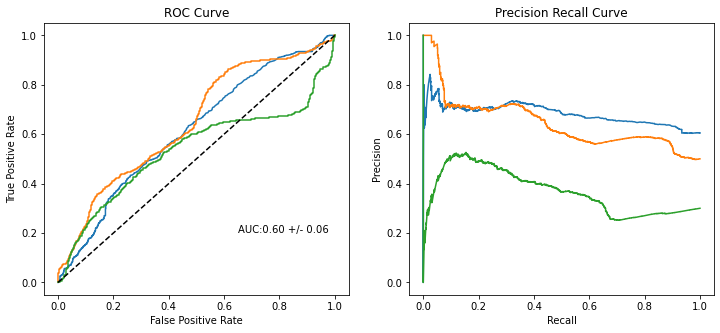

In [37]:
fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12, 5))
#fig.suptitle(y_Var)

for _, row in results.iterrows():
    
    ax.plot(row["FPR_curve"], row["TPR_curve"])
    
ax.plot([0,1],[0,1], c = "black", linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

ax.text(0.65, 0.2, "AUC:{:.2f} +/- {:.2f}".format(results["AUC"].mean(), results["AUC"].std()))

for _, row in results.iterrows():
    
    ax2.plot(row["rec_curve"], row["prec_curve"])
    
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve');

fig.savefig(os.path.join(file_place, "ROC_scores.png"), bbox_inches = 'tight')

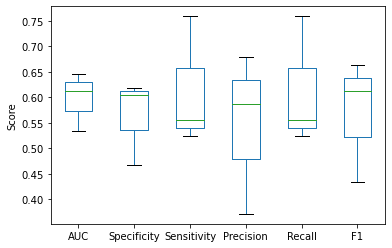

In [38]:
fig, ax = plt.subplots(ncols = 1)

results[["AUC", "Specificity", "Sensitivity", "Precision", "Recall", "F1"]].plot.box(ax = ax)
ax.set_ylabel("Score");

results.to_excel(os.path.join(file_place, "Confusion_Matrix_bad.xlsx"))
fig.savefig(os.path.join(file_place, "scores.png"), bbox_inches = 'tight')

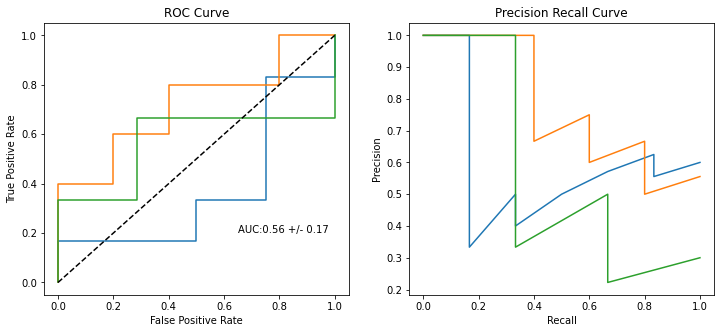

In [39]:
fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12, 5))
#fig.suptitle(y_Var)

for _, row in results.iterrows():
    
    ax.plot(row["Pat_FPR_curve"], row["Pat_TPR_curve"])
    
ax.plot([0,1],[0,1], c = "black", linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

ax.text(0.65, 0.2, "AUC:{:.2f} +/- {:.2f}".format(results["Pat_AUC"].mean(), results["Pat_AUC"].std()))

for _, row in results.iterrows():
    
    ax2.plot(row["Pat_rec_curve"], row["Pat_prec_curve"])
    
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve');

fig.savefig(os.path.join(file_place, "pat_ROC_scores.png"), bbox_inches = 'tight')

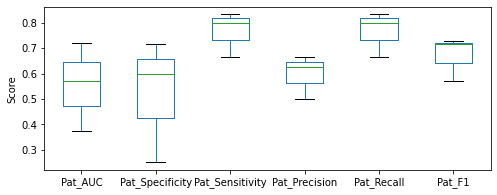

In [40]:
fig, ax = plt.subplots(ncols = 1, figsize=(8,3))

results[["Pat_AUC", "Pat_Specificity", "Pat_Sensitivity", "Pat_Precision", "Pat_Recall", "Pat_F1"]].plot.box(ax = ax)
ax.set_ylabel("Score");

results.to_excel(os.path.join(file_place, "Confusion_Matrix_bad.xlsx"))
fig.savefig(os.path.join(file_place, "pat_scores.png"), bbox_inches = 'tight')

In [43]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
y_Var = "ECS"

data = new_metadata.copy().dropna(subset = ["ASMA"])#.loc[:,["ASMA"]]

X = data.loc[:,["ASMA"]]
y = pd.DataFrame(lb.fit_transform(data.reset_index()[f"{y_Var}"])).iloc[:,0]


OHE = OneHotEncoder(sparse = False)
#OHE.fit(data.reset_index()["ASMA"].values.reshape(-1,1))

categorical_pipe = Pipeline([
    ("OneHot", OHE)
])

pipe = Pipeline([
    ("Preprocessing", categorical_pipe),
    ("clf", LinearDiscriminantAnalysis())
])

scores = []

for train_i, test_i in StratifiedKFold(5, shuffle = True).split(X, y):
    
    clf = pipe.fit(X.iloc[train_i], y.iloc[train_i])
    
    scores.append(Cross_Eval.score(clf, X.iloc[test_i], y.iloc[test_i]))
    
results = pd.DataFrame(scores)

In [ ]:
fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12, 5))
#fig.suptitle(y_Var)

for _, row in results.iterrows():
    
    ax.plot(row["FPR_curve"], row["TPR_curve"])
    
ax.plot([0,1],[0,1], c = "black", linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

ax.text(0.65, 0.2, "AUC:{:.2f} +/- {:.2f}".format(results["AUC"].mean(), results["AUC"].std()))

for _, row in results.iterrows():
    
    ax2.plot(row["rec_curve"], row["prec_curve"])
    
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve');

#fig.savefig(os.path.join(file_place, "ROC_scores.png"), bbox_inches = 'tight')

In [ ]:
fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12, 5))
#fig.suptitle(y_Var)

for _, row in results.iterrows():
    
    ax.plot(row["FPR_curve"], row["TPR_curve"])
    
ax.plot([0,1],[0,1], c = "black", linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

ax.text(0.65, 0.2, "AUC:{:.2f} +/- {:.2f}".format(results["AUC"].mean(), results["AUC"].std()))

for _, row in results.iterrows():
    
    ax2.plot(row["rec_curve"], row["prec_curve"])
    
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve');

#fig.savefig(os.path.join(file_place, "ROC_scores.png"), bbox_inches = 'tight')

In [ ]:
results.describe()

In [ ]:
fig, ax = plt.subplots(ncols = 1)
fig.suptitle(y_Var)

results[["AUC", "Specificity", "Sensitivity", "Precision", "Recall", "F1"]].plot.box(ax = ax)
ax.set_ylabel("Score");

#results.to_excel(os.path.join(file_place, "Confusion_Matrix_bad.xlsx"))
#fig.savefig(os.path.join(file_place, "scores.png"), bbox_inches = 'tight')

In [ ]:
fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12, 5))
fig.suptitle(title)

for _, row in results.iterrows():
    
    ax.plot(row["FPR_curve"], row["TPR_curve"])
    
ax.plot([0,1],[0,1], c = "black", linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')

ax.text(0.65, 0.2, "AUC:{:.2f} +/- {:.2f}".format(results["AUC"].mean(), results["AUC"].std()))

for _, row in results.iterrows():
    
    ax2.plot(row["rec_curve"], row["prec_curve"])
    
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve')

fig.savefig(os.path.join(file_place, "ROC_scores.png"), bbox_inches = 'tight')

In [ ]:
results.describe()

In [ ]:
fig, ax = plt.subplots(ncols = 1)
fig.suptitle(title)

results[["AUC", "Specificity", "Sensitivity", "Precision", "Recall", "F1"]].plot.box(ax = ax)
ax.set_ylabel("Score")

results.to_excel(os.path.join(file_place, "Confusion_Matrix_bad.xlsx"))
fig.savefig(os.path.join(file_place, "scores.png"), bbox_inches = 'tight')

## Repeat evaluation on patient basis

In [ ]:
y_pred

In [ ]:
Cross_Eval.patient_score(results)

In [ ]:
results.T

In [ ]:
results.y_true.values[0]

In [ ]:
results

In [ ]:
patient_preds = results.y_pred.copy()
patient_preds["predictions"] = predictions
patient_preds.index = X_valid.index

In [ ]:
def agg_scores(columns):
    
    return columns.sum()/columns.size

In [ ]:
patient_preds.groupby("Patient_Number").agg(agg_scores)

In [ ]:
y_true = patient_preds.groupby("Patient_Number").agg(agg_scores).loc[:, 0]
y_pred = patient_preds.groupby("Patient_Number").agg(agg_scores).loc[:,"predictions"]

y_pred_nopt = np.array([0 if score < 0.5 else 1 for score in y_pred])
y_pred_opt = np.array([0 if score < opt else 1 for score in y_pred])

fpr, tpr, t = roc_curve(y_true, y_pred)
AUC = roc_auc_score(y_true, y_pred)

scores = np.array([np.sqrt(((1-t)**2)+((0-(f))**2)) for f, t in zip(fpr,tpr)])
threshi = np.argmin(scores)

prec, rec, _ = precision_recall_curve(y_true, y_pred)

opt = t[threshi]

In [ ]:
fig, ax = plt.subplots()

ax.plot(t , scores, label = "Score")
#ax.plot(t , tpr, label = "True positive rate")
#ax.plot(t , fpr, label = "False positive rate")
ax.set_title('Optimal decision threshold')
ax.set_xlabel("Threshold")
ax.set_ylabel("$\sqrt{(1-FPR)^2 + (0-TPR)^2}$")
ax.axvline(opt, c = "r")
ax.text(opt + 0.1, 0.95, f"Opt threshold {opt:.2f}")
ax.legend()

fig.savefig(os.path.join(file_place, "Optimal_Thresh.png"), bbox_inches = 'tight')

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [ ]:
fig, (ax, ax2) = plt.subplots(ncols = 2, figsize = (12, 5))

ax.plot(fpr, tpr)
ax.plot([0,1],[0,1], linestyle = '--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ECS ROC Curve')
ax.plot([0, fpr[threshi]], [1, tpr[threshi]], linestyle = "--")
ax.text(0.8, 0.2, f"AUC {AUC:.2f}")

ax2.plot(rec, prec)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve')

fig.savefig(os.path.join(file_place, "ROC_Curve_Opt.png"), bbox_inches = 'tight')

In [ ]:
scorers = {
"Weighted Accuracy" : scoring(y_true, y_pred_nopt, metric = 'average per-class accuracy'),
"Specificity" : scoring(y_true, y_pred_nopt, metric = 'specificity'),
"Sensitivity": scoring(y_true, y_pred_nopt, metric = 'sensitivity'),
"F1_Score" : f1_score(y_true, y_pred_nopt, average = 'weighted')
    }

print("weighted accuracy: \t{:.2f}".format(scoring(y_true, y_pred_nopt, metric = 'average per-class accuracy')))
print("specificity: \t\t{:.2f}".format(scoring(y_true, y_pred_nopt, metric = 'specificity')))
print("sensitivity: \t\t{:.2f}".format(scoring(y_true, y_pred_nopt, metric = 'sensitivity')))
print("F1: \t\t\t{:.2f}".format(f1_score(y_true, y_pred_nopt, average = 'weighted')))

scorers = pd.DataFrame({"Score": scorers}).round(2)
scorers.to_excel(os.path.join(os.getcwd(), "Confusion_Matrix_bad.xlsx"))

fig = plotCM(y_true, y_pred_nopt, np.unique(y_valid))
#fig.savefig(os.path.join(file_place, "Confusion_Matrix_bad.png"), bbox_inches = 'tight')

In [ ]:
scorers = {
#"Weighted Accuracy" : scoring(y_valid_b, predictions, metric = 'average per-class accuracy'),
"Specificity" : scoring(y_true, y_pred_opt, metric = 'specificity'),
"Sensitivity": scoring(y_true, y_pred_opt, metric = 'sensitivity'),
"F1_Score" : f1_score(y_true, y_pred_opt, average = 'weighted')
    }

print("weighted accuracy: \t{:.2f}".format(scoring(y_true, y_pred_opt, metric = 'average per-class accuracy')))
print("specificity: \t\t{:.2f}".format(scoring(y_true, y_pred_opt, metric = 'specificity')))
print("sensitivity: \t\t{:.2f}".format(scoring(y_true, y_pred_opt, metric = 'sensitivity')))
print("F1: \t\t\t{:.2f}".format(f1_score(y_true, y_pred_opt, average = 'weighted')))

scorers = pd.DataFrame({"Score": scorers}).round(2)
scorers.to_excel(os.path.join(file_place, "scores.xlsx"))

fig = plotCM(y_true, y_pred_opt, np.unique(y_valid))
#fig.savefig(os.path.join(file_place, "Confusion_Matrix_good.png"), bbox_inches = 'tight')

In [ ]:
pred_results = y_valid_b.copy()
pred_results.columns = ["True"]
pred_results['Prediction'] = predictions

scores.to_excel(os.path.join(file_place, "score.xlsx"))
pred_results.to_excel(os.path.join(file_place, "predictions.xlsx"))